In [2]:
figpath = '/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/Revision/figures'

## Import required modules

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import session_info
session_info.show()

In [5]:
# import a module given the full path?
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/ROIenrichment.py")
ROIenrichment = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = ROIenrichment
spec.loader.exec_module(ROIenrichment)

spec = importlib.util.spec_from_file_location("module.name", "/home/jovyan/projects/P46_Adult-heart_Visium/notebooks/ver8regions_torepo/_utils.py")
_utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = _utils
spec.loader.exec_module(_utils)

In [6]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200)

## Prepare functions

In [ ]:
def plot_ROIenrichment_bar(adata, 
                           roi,
                           groups, # list
                           category_name,
                           groupby='region',
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 10,
                           p_adj_thresh = 0.05,
                           figsize = (3,3),
                           title_fontsize = 20,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2,1)
                          ):
    # select groups which has the roi
    _df = pd.crosstab(adata.obs[groupby],adata.obs[category_name])
    _df = _df.loc[groups,roi]
    groups = list(_df.index[_df>0])
    
    if len(groups) == 1:
        
        grp = groups[0]
        slide = adata[adata.obs[groupby]==grp]

        # remove prop-cellstates which doesn't exist in the region
        rm_list = [x for x in np.sum(slide.obs)[np.sum(slide.obs)==0].index if 'prop_' in x]
        slide.obs.drop(rm_list, axis=1, inplace=True)

        # ROI enrichment calculation
        res=ROIenrichment.ROI_enrichment_allcomparison(slide,roi=roi,category_name=category_name)
        res=res.sort_values('logOR',ascending=False)

        if filtering=='rank_pos':
            res = res[:n_rank].copy()
        elif filtering=='pval_pos':
            res=res[(res['p_adj']<p_adj_thresh)&(res['logOR']>0)]
        else:
            if filtering!=None:
                raise KeyError('invalid <filtering>')

        # plotting
        plt.rcParams["figure.dpi"] = 200
        # hide grid
        plt.rcParams['axes.grid'] = False
        plt.figure(figsize=figsize)
        color = ['#870052' if x<p_adj_thresh else 'grey' for x in res['p_adj']]
        plt.bar(res['cell'], res['logOR'], yerr=res['ebar'], color=color)
        plt.title(f'{grp}, {roi}', fontdict={'fontsize':title_fontsize})
        plt.ylabel('logOR')
        plt.xticks(rotation= 90)
        plt.legend(handles=[plt.Rectangle((0,0),1,1, color='#870052')],
                   labels=['p_adj < '+str(p_adj_thresh)],
                   fontsize=legend_fontsize)

        plt.margins(x=0.03)
        # plt.savefig(f'{figpath}/{region}_{roi}_roienrich.pdf')
        plt.show()
        
    elif len(groups) > 1:
    
        # plotting
        plt.rcParams["figure.dpi"] = 200
        # hide grid
        plt.rcParams['axes.grid'] = False
        fig, axs = plt.subplots(nrows=1, ncols=len(groups), figsize=figsize)
        fig.autofmt_xdate(rotation=90, ha='center')
    
        for i,grp in enumerate(groups):
            
            slide = adata[adata.obs[groupby]==grp]
            
            n_spots_in_roi = len(slide[slide.obs[category_name]==roi])
            if n_spots_in_roi == 0:
                continue
            
            # remove prop-cellstates which doesn't exist in the region
            rm_list = [x for x in np.sum(slide.obs)[np.sum(slide.obs)==0].index if 'prop_' in x]
            slide.obs.drop(rm_list, axis=1, inplace=True)

            # ROI enrichment calculation
            res=ROIenrichment.ROI_enrichment_allcomparison(slide,roi=roi,category_name=category_name)
            res=res.sort_values('logOR',ascending=False)

            if filtering=='rank_pos':
                res=res[:n_rank].copy()
            elif filtering=='pval_pos':
                res=res[(res['p_adj']<p_adj_thresh)&(res['logOR']>0)]
            else:
                if filtering!=None:
                    raise KeyError('invalid <filtering>')
                    
            color = ['#870052' if x<p_adj_thresh else 'grey' for x in res['p_adj']]
            axs[i].bar(res['cell'], res['logOR'], yerr=res['ebar'], color=color)
            axs[i].set_title(f'{grp}', fontdict={'fontsize':title_fontsize})
            axs[i].set_ylabel('logOR')
            axs[i].margins(x=0.03)
            
            if i==0:
                fig.suptitle(roi, fontsize=title_fontsize)
            
            if i==(len(groups)-1):
                plt.legend(handles=[plt.Rectangle((0,0),1,1, color='#870052')],
                           labels=['p_adj < '+str(p_adj_thresh)],
                           fontsize=legend_fontsize, bbox_to_anchor=bbox_to_anchor)
            
            del slide,res,color 
        
        plt.tight_layout()
        # plt.savefig(f'{figpath}/{region}_{roi}_roienrich.pdf')
        plt.show()

## Read in anndata

In [8]:
# still need to confirm AVN_transition!!

adata_vis = _utils.read_visium('/nfs/team205/heart/anndata_objects/8regions/visium-OCT_adult-8reg-revision_raw.h5ad',
                               lognorm=True, cellname_convert=False)
adata_vis

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


AnnData object with n_obs × n_vars = 81007 × 23196
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'n_counts', 'n_genes', 'annotation_JC', 'sangerID', 'Publication', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'region_cell2loc', 'annotation_final', 'Adip1', 'Adip2', 'Adip3', 'B', 'B_plasma', 'CD14+Mo', 'CD16+Mo', 'CD4+T_act', 'CD4+T_naive', 'CD8+T_cytox', 'CD8+T_em', 'CD8+T_te', 'CD8+T_trans', 'DC', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap', 'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_endocardial', 'EC8_ln', 'FB1', 'FB2', 'FB3', 'FB4_activated', 'FB5', 'FB6', 'ILC', 'LYVE1+IGF1+MP', 'LYVE1+MP_cycling', 'LYVE1+TIMD4+MP', 'MAIT-like', 'Mast', 'Meso', 'MoMP', 

In [9]:
category_name='annotation_final'

In [10]:
set(adata_vis.obs[category_name])

{'AV_bundle',
 'adipose_tissue',
 'cardiac_skeleton',
 'endocardium',
 'epicardium_subepicardium',
 'fibrosis',
 'haemorrhage',
 'membraneous_septum',
 'myocardium',
 'myocardium_atrial',
 'myocardium_ventricular',
 'nerve',
 'node',
 'purkinje-like',
 'vessel'}

## Each region, each structure

In [16]:
pd.crosstab(adata_vis.obs['region'],adata_vis.obs['annotation_final']).T

region                      AVN    AX    LA    LV    RA    RV   SAN    SP
annotation_final                                                         
AV_bundle                  1319     0     0     0     0     0     0   245
adipose_tissue              808   180    19   170   181   308  2564    49
cardiac_skeleton           3187     0     0     0     0     0     0     0
endocardium                  16    72   439     0   274     0   209    18
epicardium_subepicardium      0    37   864   356  1378   173   595     0
fibrosis                   2095   545   290   478   352     8   369   265
haemorrhage                   0     0     0     0     0     0   127     0
membraneous_septum         1423     0     0     0     0     0     0     0
myocardium                    0  5628  3947  8519  4676  4457  4466  5629
myocardium_atrial          1468     0     0     0     0     0  2974     0
myocardium_ventricular    13382     0     0     0     0     0     0  2311
nerve                         0     0     3     6     2    10   226     0
node                        246     0     0     0     0     0  2495     0
purkinje-like                 0     0     0     0     0     0     0    40
vessel                       82    35   260    97   164    83   302    86

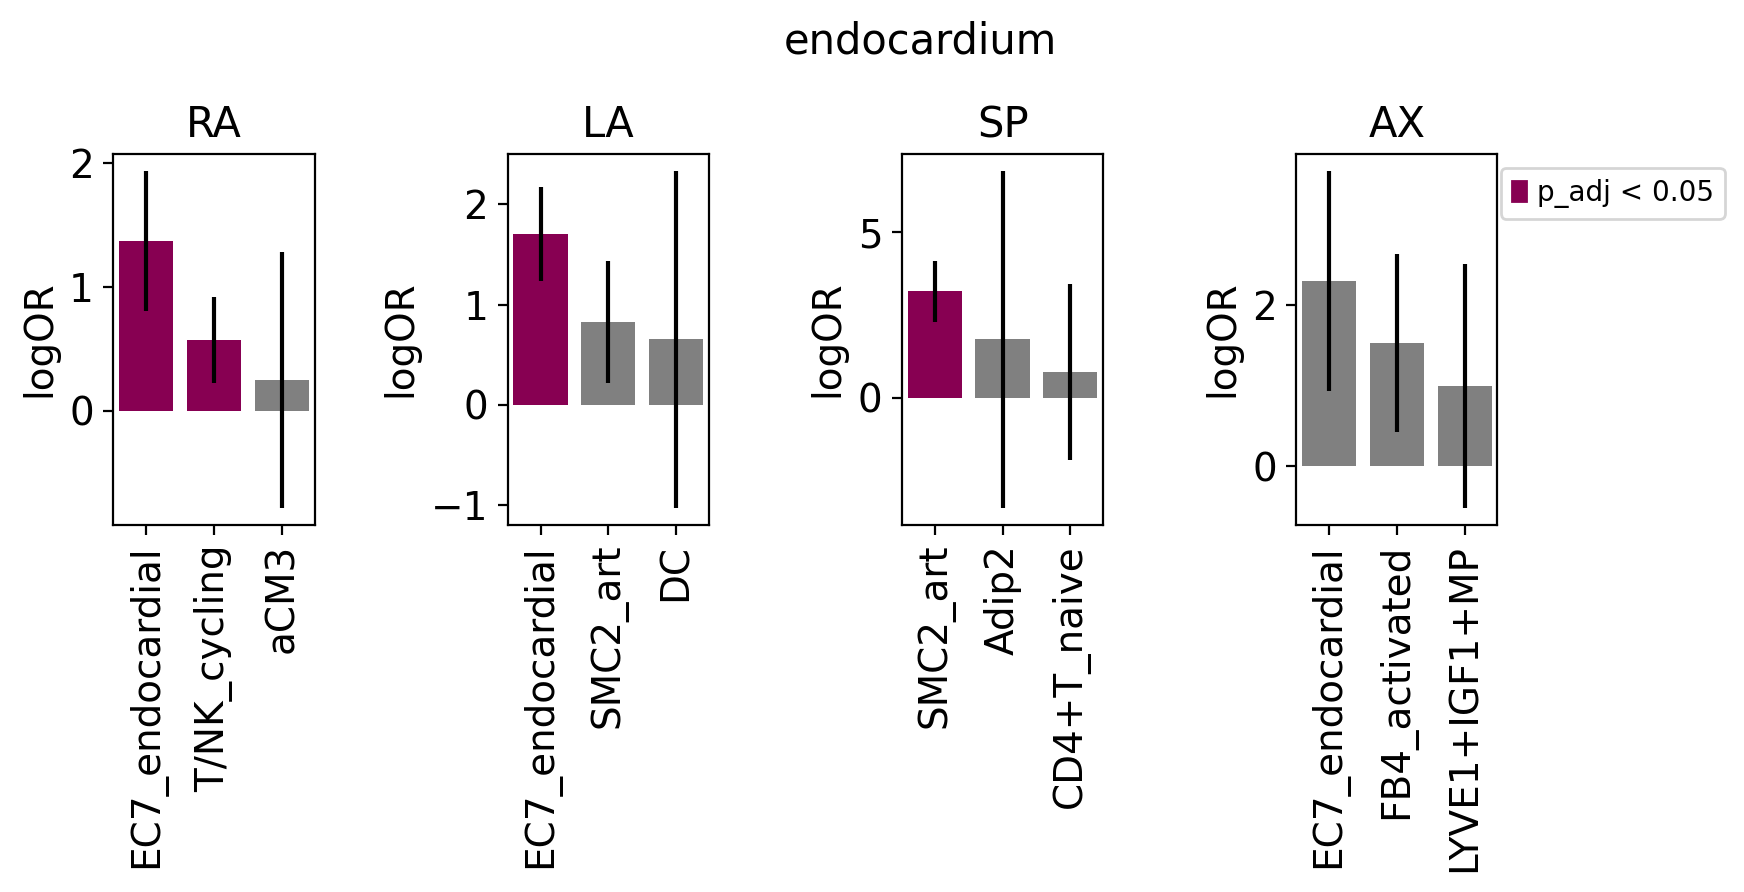

In [47]:
plot_ROIenrichment_bar(adata = adata_vis, 
                           roi = 'endocardium',
                           groups = ['RA','LA','RV','LV','SP','AX'], # list
                           groupby='region',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 3,
                           p_adj_thresh = 0.05,
                           figsize = (10,4.5),
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2.2,1)
                          )

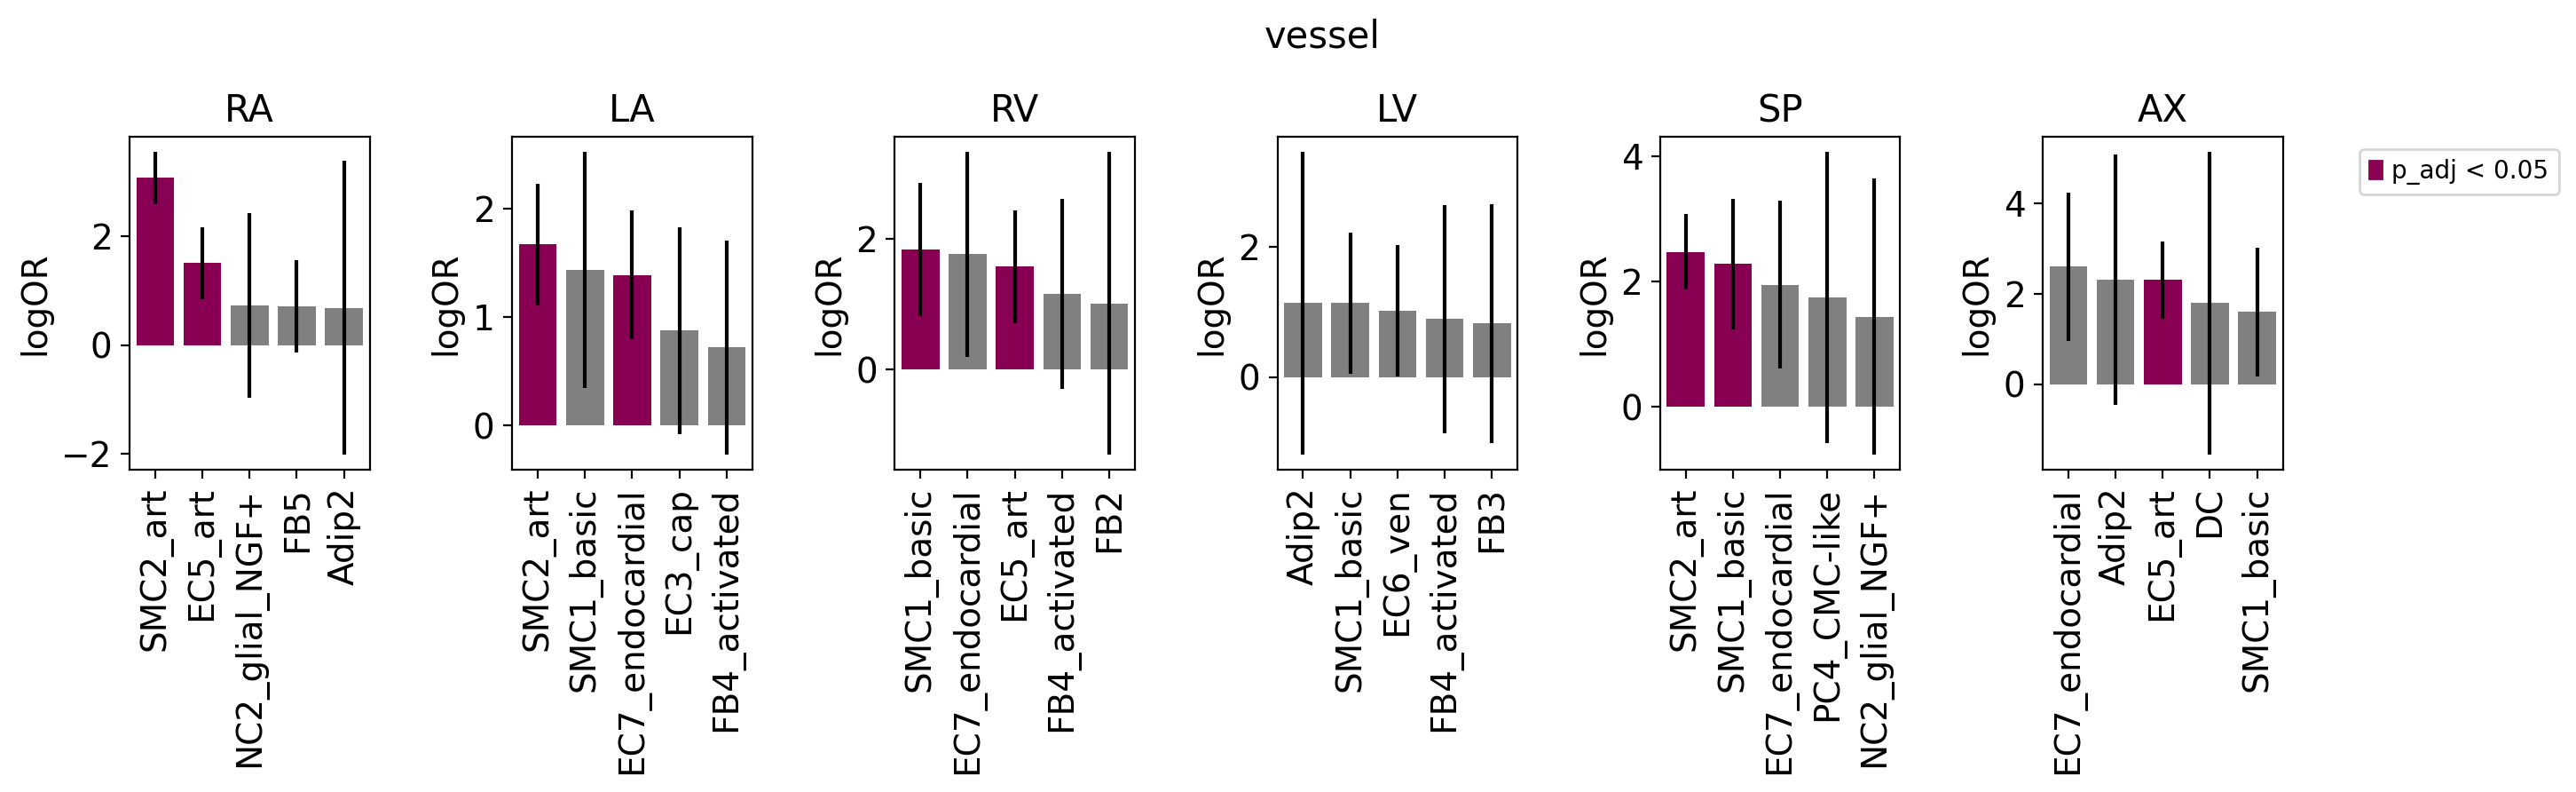

In [48]:
plot_ROIenrichment_bar(adata = adata_vis, 
                           roi = 'vessel',
                           groups = ['RA','LA','RV','LV','SP','AX'], # list
                           groupby='region',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 5,
                           p_adj_thresh = 0.05,
                           figsize = (15,4.5),
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2.2,1)
                          )

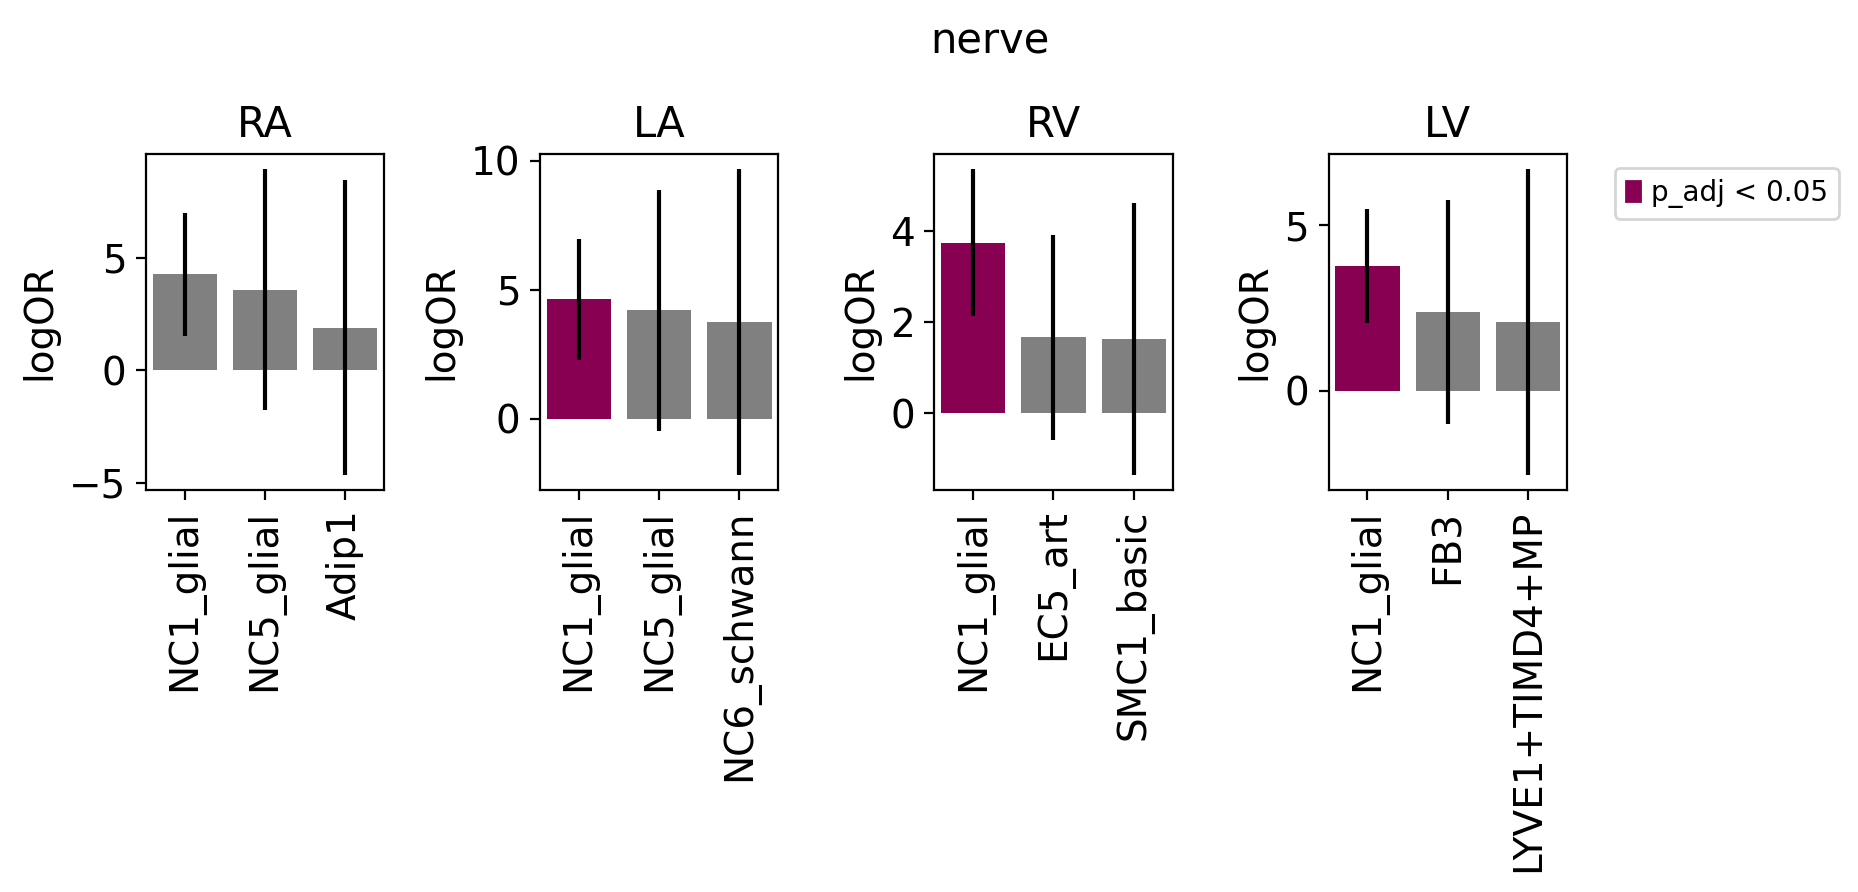

In [49]:
plot_ROIenrichment_bar(adata = adata_vis, 
                           roi = 'nerve',
                           groups = ['RA','LA','RV','LV','SP','AX'], # list
                           groupby='region',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 3,
                           p_adj_thresh = 0.05,
                           figsize = (10,4.5),
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2.2,1)
                          )

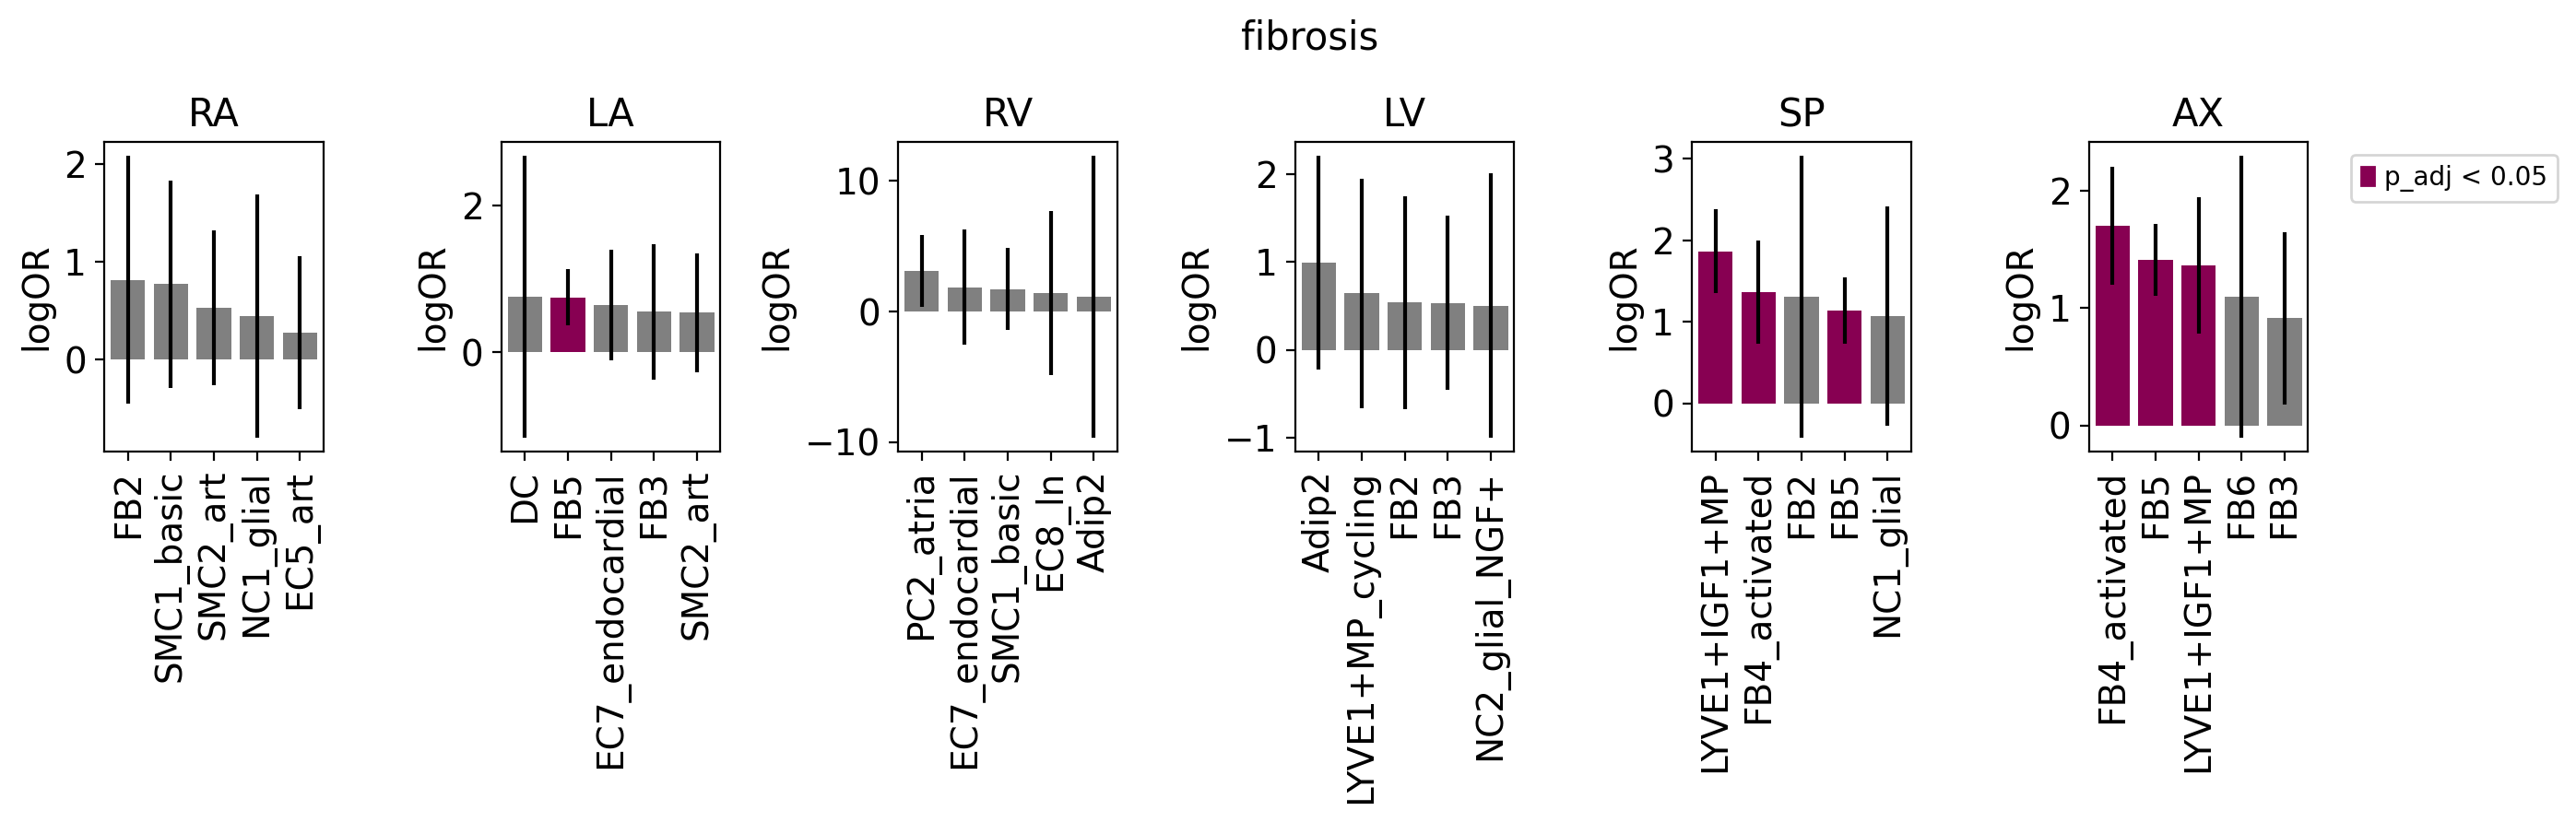

In [50]:
plot_ROIenrichment_bar(adata = adata_vis, 
                           roi = 'fibrosis',
                           groups = ['RA','LA','RV','LV','SP','AX'], # list
                           groupby='region',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 5,
                           p_adj_thresh = 0.05,
                           figsize = (15,4.5),
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2.2,1)
                          )

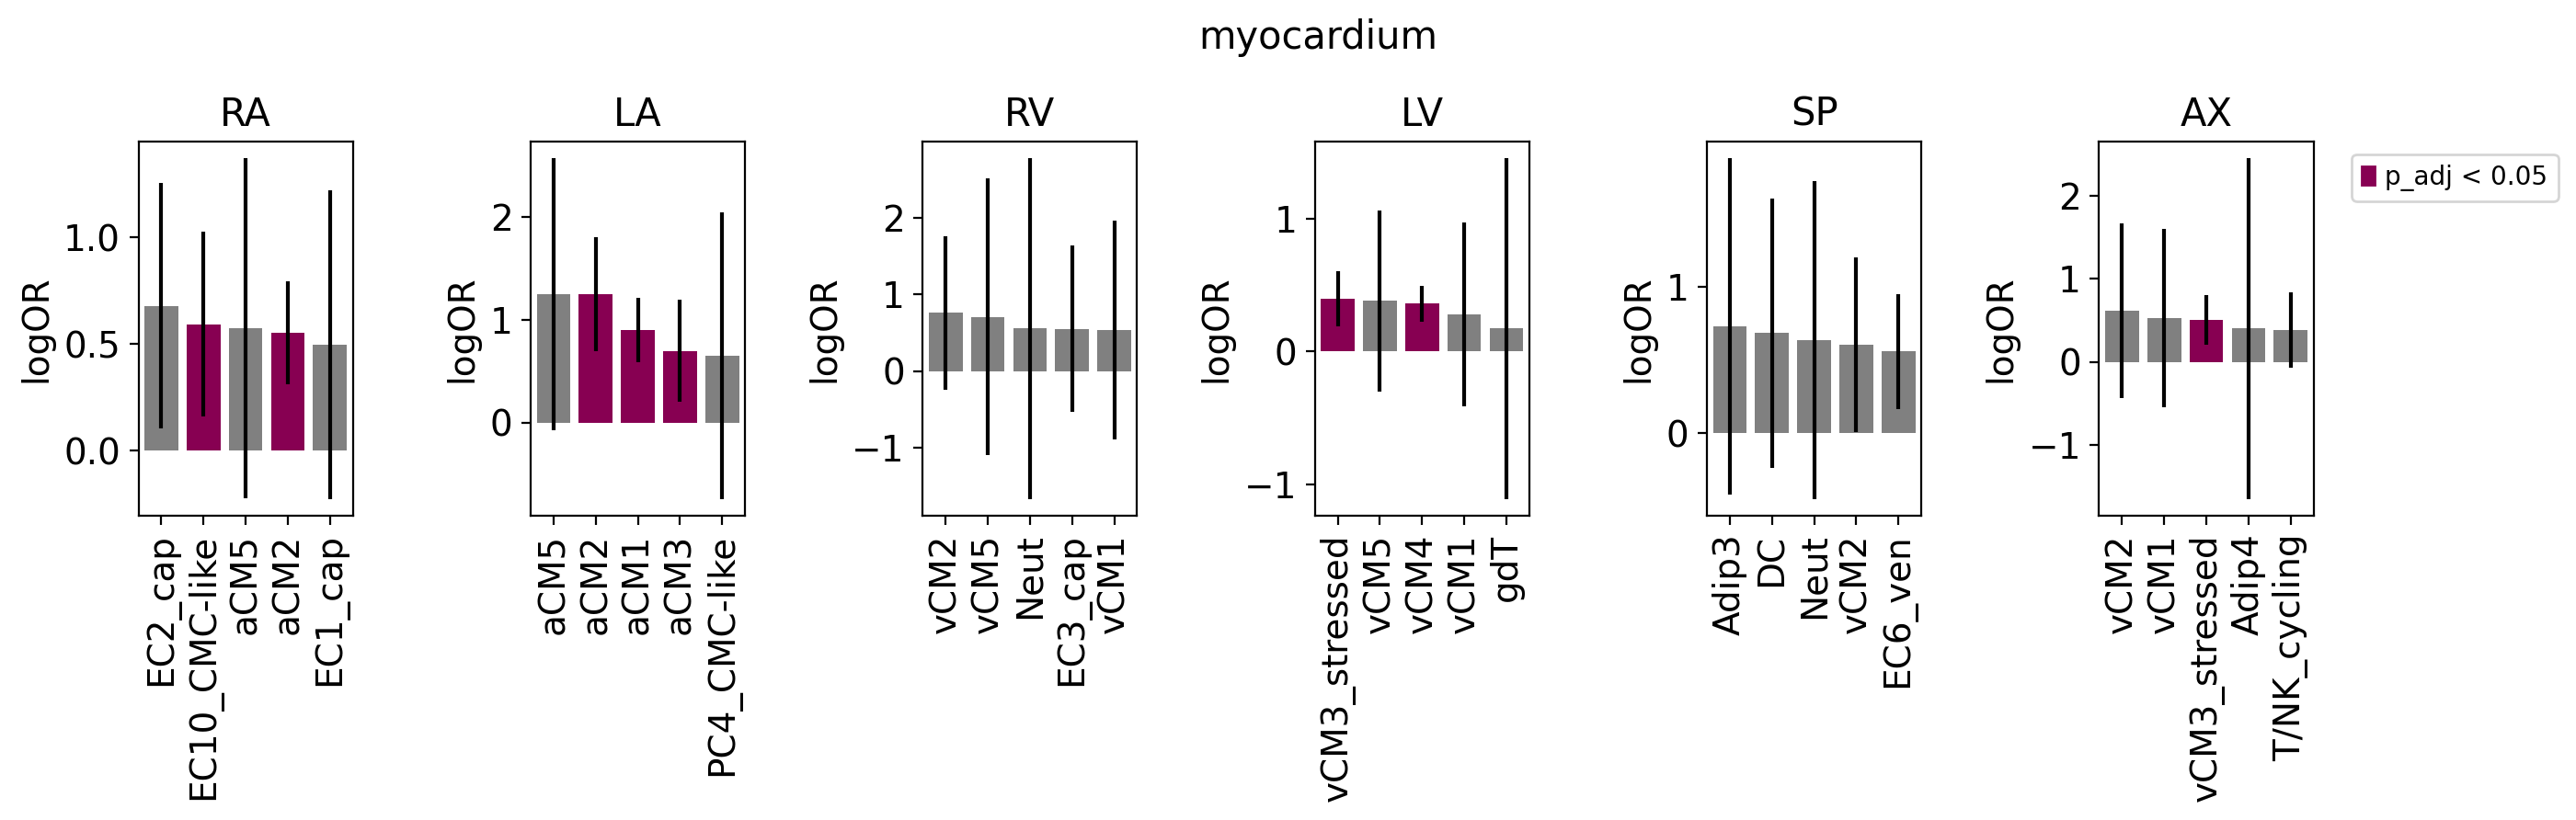

In [51]:
plot_ROIenrichment_bar(adata = adata_vis, 
                           roi = 'myocardium',
                           groups = ['RA','LA','RV','LV','SP','AX'], # list
                           groupby='region',
                           category_name = category_name,
                           filtering = 'rank_pos',  # select from 'rank_pos','pval_pos','rank_both','pval_both'
                           n_rank = 5,
                           p_adj_thresh = 0.05,
                           figsize = (15,4.5),
                           title_fontsize = 15,
                           legend_fontsize = 10,
                           bbox_to_anchor = (2.2,1)
                          )

## Visium plots

In [52]:
rep_slide_dict = {
    'SAN':['HCAHeartST10659160'],
    'SAN-FFPE':['HCAHeartST11702010'],
    # 'AVN_AVN':['HCAHeartST11290662'],
    'AVN_AVbundle':['HCAHeartST11290658'],
    'RA':['HCAHeartST8795937'],
    'LA':['HCAHeartST10238252'],
    'RV':['HCAHeartST8795940'],
    'LV':['HCAHeartST8795933'],
    'SP':['HCAHeartST8795939'],
    'AX':['HCAHeartST8795936'],
}

In [59]:
### ver 20230103 ###

colormap='tab20'
palette={}
palette['adipose_tissue']=plt.get_cmap(colormap).colors[0]
palette['endocardium']=plt.get_cmap(colormap).colors[1]
palette['epicardium_subepicardium']=plt.get_cmap(colormap).colors[2]
palette['fibrosis']=plt.get_cmap(colormap).colors[3]
palette['myocardium']=plt.get_cmap(colormap).colors[5]
palette['nerve']=plt.get_cmap(colormap).colors[4]
palette['node']=plt.get_cmap(colormap).colors[6]
palette['vessel']=plt.get_cmap(colormap).colors[7]
palette['AV_bundle']=plt.get_cmap(colormap).colors[8]
palette['myocardium_atrial']=plt.get_cmap(colormap).colors[9]
palette['myocardium_ventricular']=plt.get_cmap(colormap).colors[10]
palette['cardiac_skeleton']=plt.get_cmap(colormap).colors[11]
palette['membraneous_septum']=plt.get_cmap(colormap).colors[12]
palette['purkinje-like']=plt.get_cmap(colormap).colors[13]
palette['haemorrhage']=plt.get_cmap(colormap).colors[14]

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


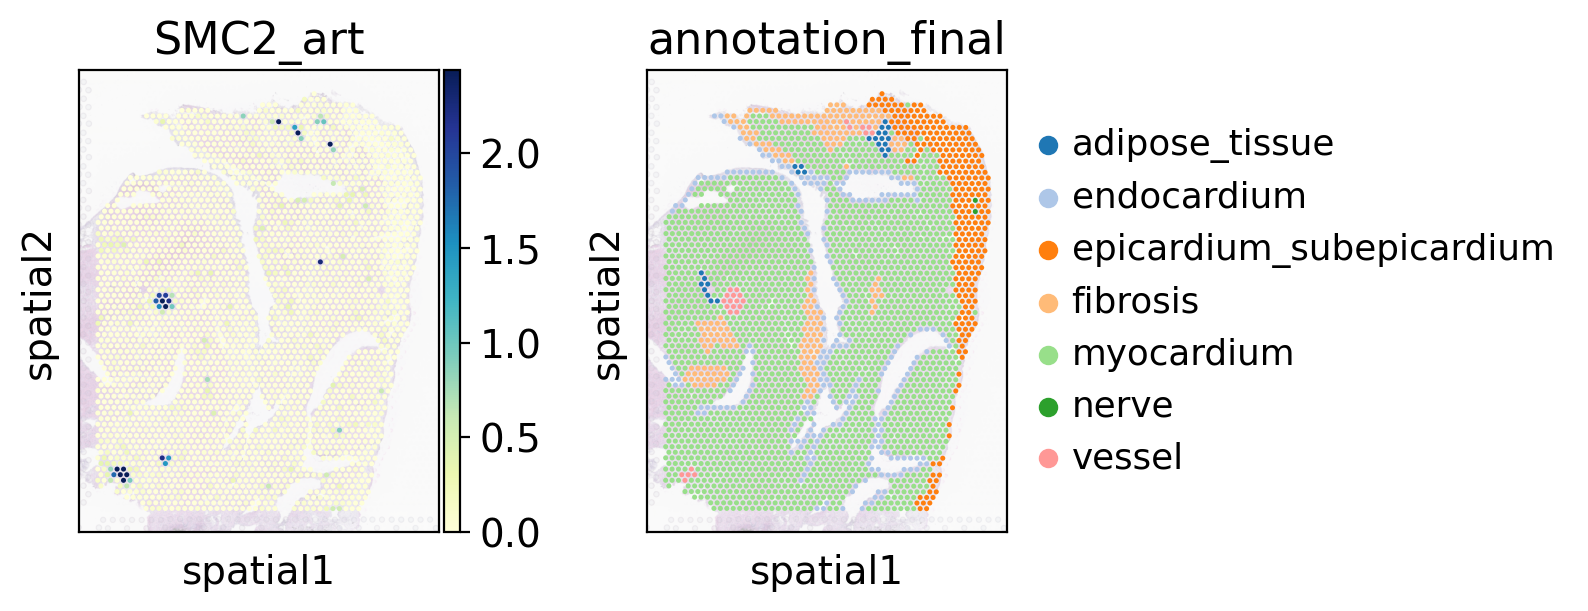

In [73]:
slide = _utils.select_multislide(adata_vis, rep_slide_dict['RA'], s_col='sample')

# endocardium
with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':16,}):
    # cells
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=[
                      'SMC2_art',
                      category_name,], 
                  ncols=5, wspace=0.2,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.7',
                  palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


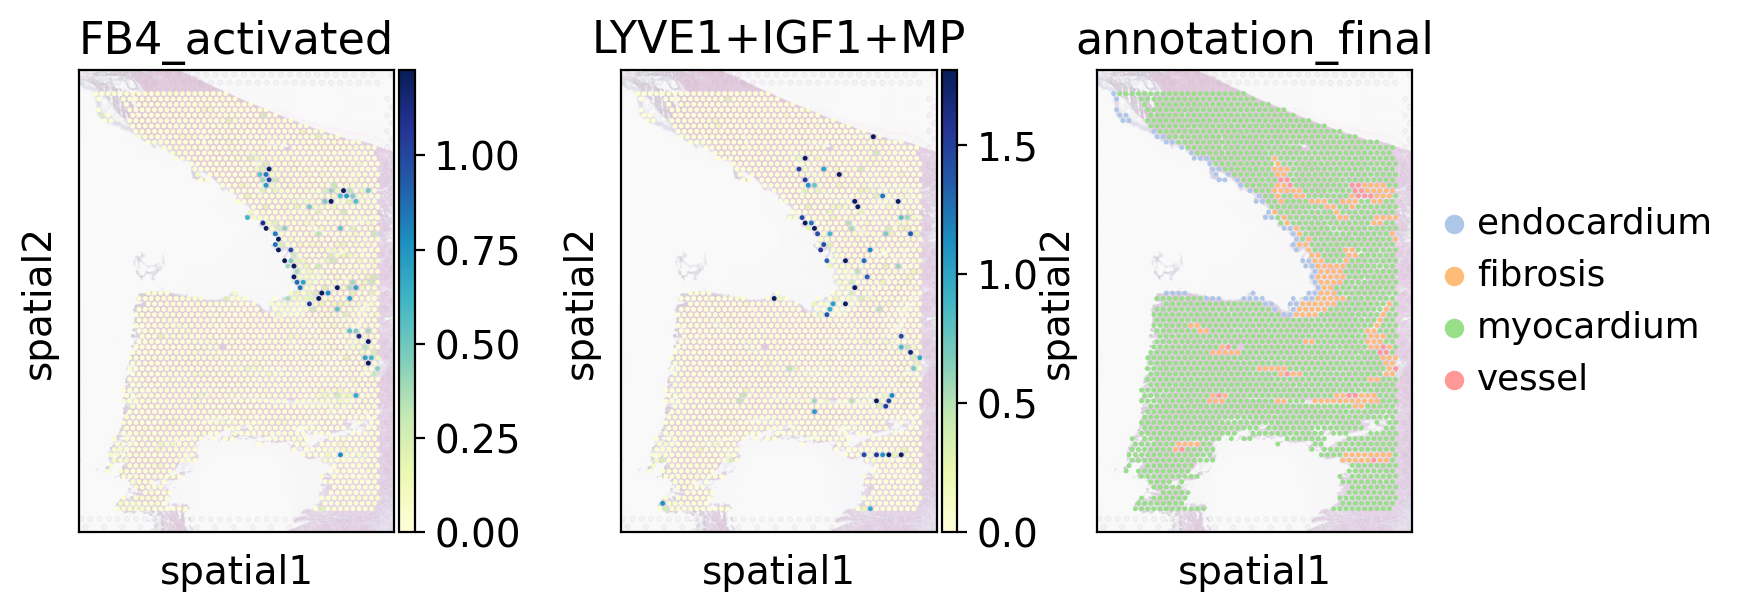

In [78]:
slide = _utils.select_multislide(adata_vis, rep_slide_dict['AX'], s_col='sample')

# endocardium
with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':16,}):
    # cells
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=[
                      'FB4_activated',
                      'LYVE1+IGF1+MP',
                      category_name,], 
                  ncols=5, wspace=0.1,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.4',
                  palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


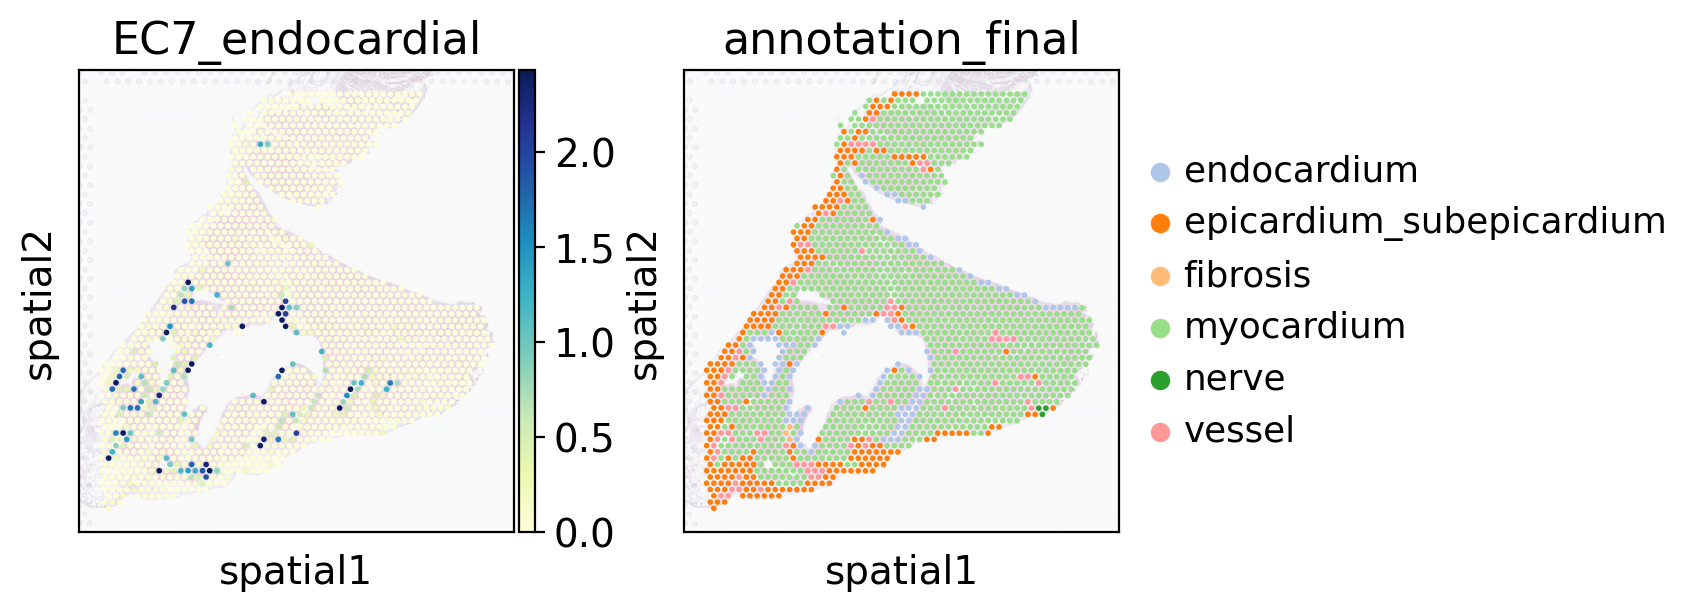

In [94]:
slide = _utils.select_multislide(adata_vis, rep_slide_dict['LA'], s_col='sample')

# endocardium
with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':16,}):
    # cells
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=[
                      'EC7_endocardial',
                      category_name,], 
                  ncols=5, wspace=0.2,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99',
                  palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


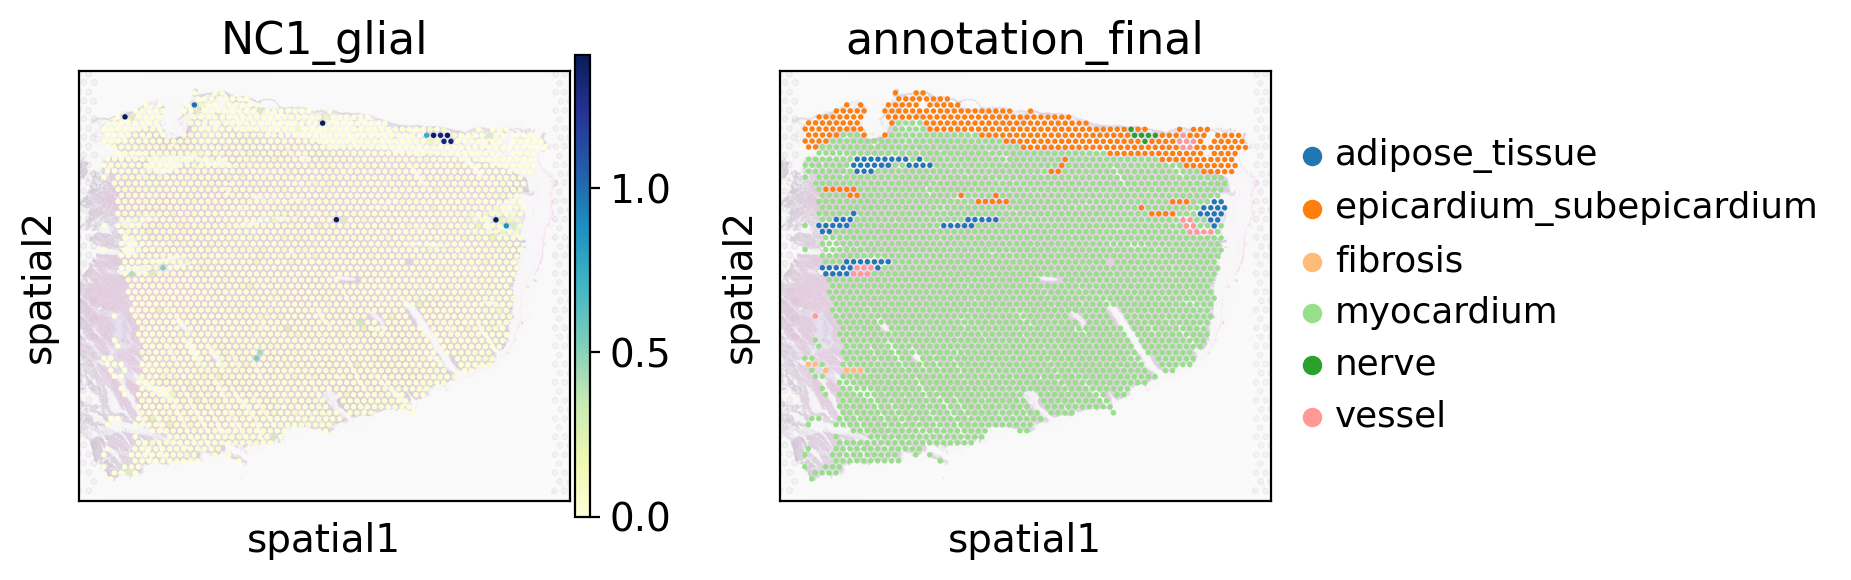

In [106]:
slide = _utils.select_multislide(adata_vis, ['HCAHeartST8795933'], s_col='sample')

# endocardium
with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':16,}):
    # cells
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=[
                      'NC1_glial',
                      category_name,], 
                  ncols=5, wspace=0.3,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.8',
                  palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


{'RV'}


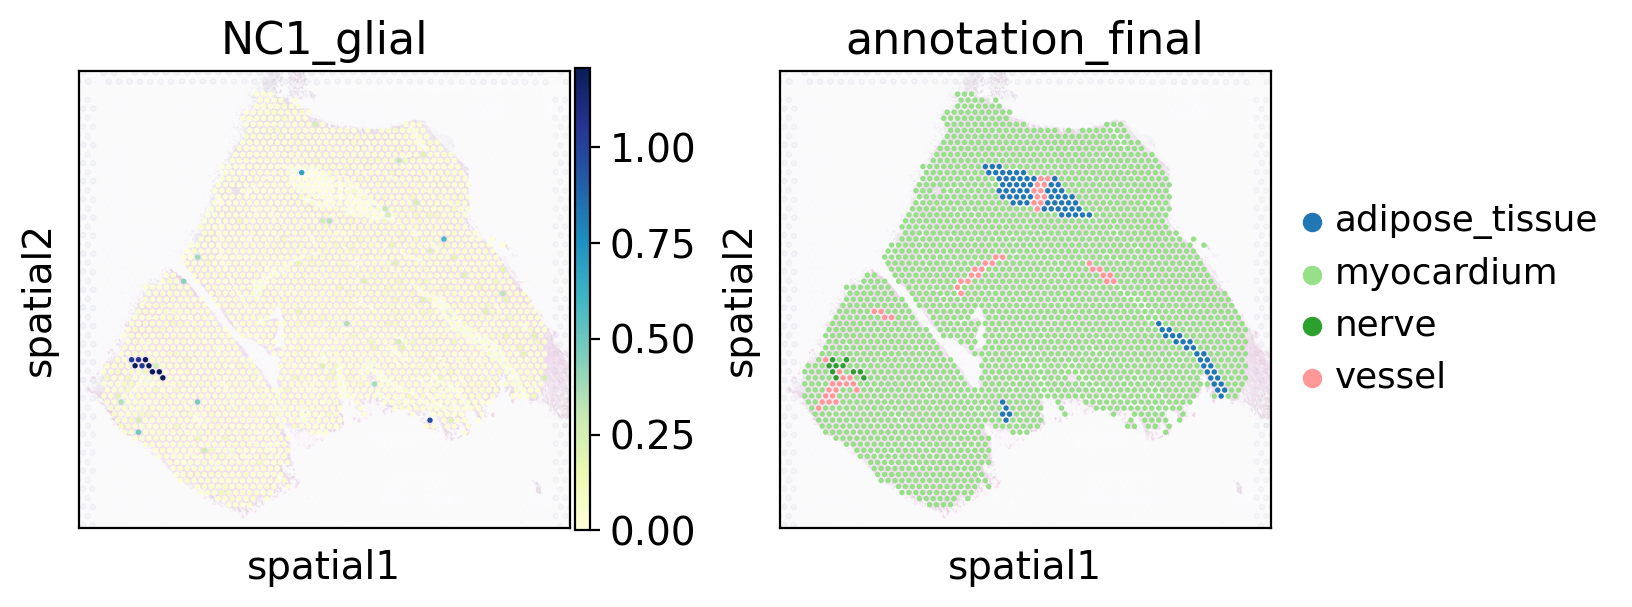

In [110]:
ID = 'HCAHeartST10550730'
slide = _utils.select_multislide(adata_vis, [ID], s_col='sample')

print(set(adata_vis[adata_vis.obs['sample']==ID].obs['region']))

# endocardium
with mpl.rc_context({'figure.figsize': [3, 3],
                            'axes.titlesize':16,}):
    # cells
    sc.pl.spatial(slide,cmap='YlGnBu',
                  color=[
                      'NC1_glial',
                      category_name,], 
                  ncols=5, wspace=0.3,hspace=0.3,
                  size=1.2,img_key='hires',alpha_img=0.3,vmin=0, vmax='p99.8',
                  palette = palette
                  # save=f'_SAN-{ID}_core_cellstates.pdf'
                 )

In [87]:
pd.crosstab(adata_vis.obs[category_name],adata_vis.obs['sample']).T

annotation_final    AV_bundle  adipose_tissue  cardiac_skeleton  endocardium  \
sample                                                                         
HCAHeartST10238251          0               0                 0            0   
HCAHeartST10238252          0               0                 0          119   
HCAHeartST10238253          0             136                 0            0   
HCAHeartST10550730          0              90                 0            0   
HCAHeartST10550732          0              14                 0            0   
HCAHeartST10659160          0             559                 0           55   
HCAHeartST11290657          0               0               883            0   
HCAHeartST11290658        171               0               834            0   
HCAHeartST11290659        133               0               315            0   
HCAHeartST11290662          0               0               719            0   
HCAHeartST11350377        148               0               436            0   
HCAHeartST8795933           0              73                 0            0   
HCAHeartST8795934           0               0                 0          259   
HCAHeartST8795935           0               0                 0           61   
HCAHeartST8795936           0               0                 0           72   
HCAHeartST8795937           0              26                 0          274   
HCAHeartST8795938           0              25                 0            0   
HCAHeartST8795939           0              10                 0            0   
HCAHeartST8795940           0              40                 0            0   
HCAHeartST9341982           0             178                 0            0   
HCAHeartST9341983           0              19                 0            0   
HCAHeartST9341984           0              44                 0            0   
HCAHeartST9383352           0               0                 0            0   
HCAHeartST9383353           0             155                 0            0   
HCAHeartST9383354           0              77                 0            0   
HCAHeartST9383355           0               0                 0            0   
HCAHeartST9383356           0              20                 0            0   
HCAHeartST9383358           0               0                 0            0   
HCAHeartST11350375        245               0                 0           18   
HCAHeartST12992072          0             427                 0          115   
HCAHeartST12992074        154               0                 0           16   
HCAHeartST12992075        523               0                 0            0   
HCAHeartST13228103        190             808                 0            0   
HCAHeartST13228105          0            1479                 0           11   
HCAHeartST13228106          0              99                 0           28   

annotation_final    epicardium_subepicardium  fibrosis  haemorrhage  \
sample                                                                
HCAHeartST10238251                       264       100            0   
HCAHeartST10238252                       271         3            0   
HCAHeartST10238253                        37       340            0   
HCAHeartST10550730                         0         0            0   
HCAHeartST10550732                         0         0            0   
HCAHeartST10659160                       399        88            0   
HCAHeartST11290657                         0         0            0   
HCAHeartST11290658                         0         0            0   
HCAHeartST11290659                         0       181            0   
HCAHeartST11290662                         0       138            0   
HCAHeartST11350377                         0       188            0   
HCAHeartST8795933                        333         6            0   
HCAHeartST8795934                        296 